In [20]:
import warnings
warnings.filterwarnings("ignore")

### 패션 mnist 불러오기 

In [21]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
# 2차원을 3차원으로 추가, 표준화
train_scaled = train_input.reshape(-1, 28, 28,1) / 255.0 
# 훈련과 검증용으로 나눈기
train_scaled, val_scaled, train_target,val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state=42
) # val_scaled = test size


In [22]:
len(train_scaled)

48000

In [23]:
len(val_scaled)

12000

- keras에서 입력데이터가 3차원으로 구성된 데이터라 가정하므로 차원을 추가해서 channel 차원으로 1을 추가하였음
- train set을 train과 valid로 구분

### 합성곱 신경망 만들기

In [24]:
model = keras.Sequential()

In [25]:
# 1 
# same padding, 같은 사이즈의 특성맵 생성 
model.add(
    keras.layers.Conv2D(
        32, # 필터의 갯수
        kernel_size = 3, # 커널의 갯수 (3*3 => 홀수이여야함)
        activation = "relu",    # 활성함수(가중치를 더하는 방법)
        padding = 'same',
        input_shape = (28, 28,1),   # 입력층
    )
)
# 특성맵 사이즈 (28,28,32) # 

In [26]:
# 2 
# 최대풀링 (데이터 중 최대값을 택한다.(255에 가장 가까운 값))
model.add(keras.layers.MaxPooling2D(2)) # 2*2

In [27]:
# 3 
# 합성곱층 
model.add(
    keras.layers.Conv2D(
        64, # 필터의 갯수
        kernel_size = 3, # 커널의 갯수 (3*3 => 홀수이여야함)
        activation = "relu",    # 활성함수(가중치를 더하는 방법)
        padding = 'same',
    )
)

In [28]:
# 4 
model.add(keras.layers.MaxPooling2D(2))# 2*2
# maxpooling을 두번 거침 => 풀링층이 두번 

<img src="../Data/maxpooling.png">

In [29]:
# 쓰는 순서에 따라 모델이 추가되므로 순서에 유의한다.

# 풀링층을 1차원으로 변형 
model.add(keras.layers.Flatten())
# 밀집층 => 은닉층 
model.add(keras.layers.Dense(100,activation="relu"))

# 일부 탈락(과대적합 방지)
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(10,activation="softmax"))

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

# model compile과 훈련

In [31]:
model.compile(
    optimizer = "adam",
    # 손실함수
    loss = "sparse_categorical_crossentropy", # 출력층은 숫자분류 => 0~9
    metrics = "accuracy"
)
# 손실값이 적은 함수 저장 
checkpoint_db= keras.callbacks.ModelCheckpoint("../Data/best_cnn_model.h5")
# 최적의 값을 찾으면 조기 종료
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(
    train_scaled,
    train_target,
    epochs=20,
    validation_data=(val_scaled,val_target),
    callbacks = [checkpoint_db,early_stopping_cb]
)

Epoch 1/20
1500/1500 [==============================] - 28s 18ms/step - loss: 0.5092 - accuracy: 0.8195 - val_loss: 0.3174 - val_accuracy: 0.8805
Epoch 2/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.3370 - accuracy: 0.8802 - val_loss: 0.2658 - val_accuracy: 0.9007
Epoch 3/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2865 - accuracy: 0.8972 - val_loss: 0.2481 - val_accuracy: 0.9078
Epoch 4/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2537 - accuracy: 0.9081 - val_loss: 0.2361 - val_accuracy: 0.9128
Epoch 5/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.2303 - accuracy: 0.9168 - val_loss: 0.2289 - val_accuracy: 0.9144
Epoch 6/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2091 - accuracy: 0.9234 - val_loss: 0.2288 - val_accuracy: 0.9154
Epoch 7/20
1500/1500 [==============================] - 29s 19ms/step - loss: 0.1957 - accuracy: 0.9291 - val_loss: 0.2173 -

In [32]:
#검증용의 손실과 정확도 
model = keras.models.load_model("../Data/best_cnn_model.h5")
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 6ms/step - loss: 0.2137 - accuracy: 0.9244


[0.21369734406471252, 0.9244166612625122]

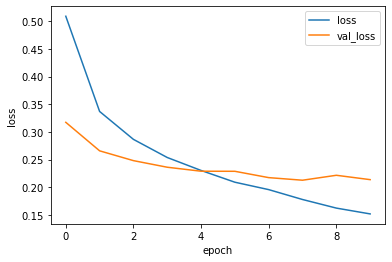

In [33]:
# 시각화 해보기
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

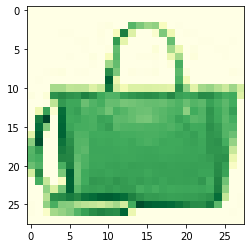

In [37]:
# 이미지 확인
plt.imshow(val_scaled[0].reshape(28,28),cmap="YlGn")
plt.show()

In [38]:
pred = model.predict(val_scaled[0:1])
print(pred)

1/1 [==============================] - 0s 23ms/step
[[1.5008849e-16 2.1030070e-26 7.6039355e-18 5.8286632e-21 7.8650007e-17
  7.6795812e-18 2.6240445e-17 1.4113318e-19 1.0000000e+00 2.5280572e-17]]


In [41]:
# 계단함수
import numpy as np
classes = ['티셔츠','팬츠','스웨터','드레스','코트','샌들','셔츠','스니커즈','가방','앵글부츠']

In [42]:
# np.argmax 최대값의 인덱스를 반환
print(classes[np.argmax(pred)])

가방


### 시험 데이터 확인해보기

In [43]:
test_scaled = test_input.reshape(-1,28,28,1) /255.0

In [44]:
model.evaluate(test_scaled,test_target)

313/313 [==============================] - 2s 6ms/step - loss: 0.2363 - accuracy: 0.9179


[0.23633037507534027, 0.917900025844574]

In [ ]:
> 6 :2 : 2의 비율 